In [1]:
from greedy_mcmc_attack import *
from data_collection.recordings import *
import sys
sys.path.append("../../")
from src.models.gcn import *
from src.models.gat import *
from src.models.gsage import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Cora')
data = cora_dataset[0].to(device)
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
edges_to_add = None

In [5]:
model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [6]:
model_save_path = "../models/cora_gcn_model.pth"
list_save_path = "../attacks/cora_gcn_edges.pth"
# # multi_metattack_edges_list.pth
# list_save_path = "multi_metattack_edges_list.pth"

In [7]:
model, edges_to_add, train = load_model_and_edges(model_save_path, list_save_path, model, device)

In [8]:
# Get initial accuracy
initial_loss, initial_accuracy = train.test(data)
print(f"Initial Accuracy: {initial_accuracy}")
print(f"Initial Loss: {initial_loss}")

Initial Accuracy: 0.759
Initial Loss: 1.9119181632995605


In [9]:
G, initial_edge_count, ptb_rate, budget = initialize(data, _ptb_rate=0.15)

In [10]:
full_metattack_acc, full_metattack_loss, full_metattack_itrs = two_phase_attack_mcmc(data, train, model, 0.0, edges_to_add, binary_fn, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/395 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/395 [00:00<?, ?it/s]

In [11]:
# splits = [0.0, 0.5, 0.7, 0.9]
# # splits = [0.9]
# split_dic_acc = defaultdict(list)
# split_dic_loss = defaultdict(list)
# itrs_one = defaultdict(int)

In [12]:
# for s in splits:
#     if s == 0.0:
#         split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
#     else:
#         split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=True, verbose=True)

In [13]:
# record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.REVERSED)
# record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"cora"}_{"constant"}_{"reversed"}_results.pkl')

In [14]:
# plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "reversed")

In [15]:
# plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "reversed")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [16]:
# split_dic_decreasing_acc = defaultdict(list)
# itrs_two = defaultdict(int)
# split_dic_decreasing_loss = defaultdict(list)

In [17]:
# for s in splits:
#     if s == 0.0:
#         split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
#     else:
#         split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=True, verbose=True)

In [18]:
# record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CORA, AcceptFn.INCREASING, SelectFn.NONE, Reverse.REVERSED)
# record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"cora"}_{"increasing"}_{"reversed"}_results.pkl')

In [19]:
# plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "reversed")

In [20]:
# plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "reversed")

# regular, secondary attack, not reversed

In [21]:
splits = [0.0, 0.5, 0.7, 0.9]
# splits = [0.9]
split_dic_acc = defaultdict(list)
split_dic_loss = defaultdict(list)
itrs_one = defaultdict(int)

In [22]:
for s in splits:
    if s == 0.0:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/197 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 22, Selected: 10
Attempt: 22, Selected: 10
Attempt: 23, Selected: 10
Attempt: 50, Selected: 20
Attempt: 51, Selected: 20
Attempt: 52, Selected: 20
Attempt: 53, Selected: 20
Attempt: 80, Selected: 30
Attempt: 111, Selected: 40
Attempt: 170, Selected: 50
Attempt: 171, Selected: 50
Attempt: 172, Selected: 50
Attempt: 218, Selected: 60
Attempt: 219, Selected: 60
Attempt: 220, Selected: 60
Attempt: 221, Selected: 60
Attempt: 222, Selected: 60
Attempt: 264, Selected: 70
Attempt: 264, Selected: 70
Attempt: 264, Selected: 70
Attempt: 297, Selected: 80
Attempt: 298, Selected: 80
Attempt: 299, Selected: 80
Attempt: 300, Selected: 80
Attempt: 301, Selected: 80
Attempt: 302, Selected: 80
Attempt: 303, Selected: 80
Attempt: 304, Selected: 80
Attempt: 305, Selected: 80
Attempt: 306, Selected: 80
Attempt: 307, Selected: 80
Attempt: 308, Selected: 80
Attempt: 309, Selected: 80
Attempt: 310, Selected: 80
Attempt: 311, Sele

Peturbing graph...:   0%|          | 0/203 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/118 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 20, Selected: 10
Attempt: 46, Selected: 20
Attempt: 47, Selected: 20
Attempt: 48, Selected: 20
Attempt: 49, Selected: 20
Attempt: 79, Selected: 30
Attempt: 116, Selected: 40
Attempt: 117, Selected: 40
Attempt: 118, Selected: 40
Attempt: 119, Selected: 40
Attempt: 210, Selected: 50
Attempt: 211, Selected: 50
Attempt: 282, Selected: 60
Attempt: 283, Selected: 60
Attempt: 284, Selected: 60
Attempt: 285, Selected: 60
Attempt: 286, Selected: 60
Attempt: 287, Selected: 60
Attempt: 288, Selected: 60
Attempt: 289, Selected: 60
Attempt: 290, Selected: 60
Attempt: 291, Selected: 60
Attempt: 292, Selected: 60
Attempt: 293, Selected: 60
Attempt: 294, Selected: 60
Attempt: 294, Selected: 60
Attempt: 295, Selected: 60
Attempt: 296, Selected: 60
Attempt: 297, Selected: 60
Attempt: 298, Selected: 60
Attempt: 405, Selected: 70
Attempt: 406, Selected: 70
Attempt: 407, Selected: 70
Attempt: 408, Selected: 70
Attempt: 409, Selected: 70
Attempt: 410,

Peturbing graph...:   0%|          | 0/123 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/39 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 23, Selected: 10
Attempt: 24, Selected: 10
Attempt: 25, Selected: 10
Attempt: 64, Selected: 20
Attempt: 86, Selected: 30
Attempt: 184, Selected: 40
Attempt: 185, Selected: 40
Attempt: 186, Selected: 40
Attempt: 187, Selected: 40
Attempt: 188, Selected: 40
Attempt: 228, Selected: 50
Attempt: 229, Selected: 50
Attempt: 230, Selected: 50
Attempt: 231, Selected: 50
Attempt: 276, Selected: 60
Attempt: 307, Selected: 70
Attempt: 308, Selected: 70
Attempt: 309, Selected: 70
Attempt: 310, Selected: 70
Attempt: 311, Selected: 70
Attempt: 312, Selected: 70
Attempt: 313, Selected: 70
Attempt: 314, Selected: 70
Attempt: 315, Selected: 70
Attempt: 316, Selected: 70
Attempt: 317, Selected: 70
Attempt: 318, Selected: 70
Attempt: 472, Selected: 80
Attempt: 473, Selected: 80
Attempt: 474, Selected: 80
Attempt: 475, Selected: 80
Attempt: 476, Selected: 80
Attempt: 477, Selected: 80
Attempt: 478, Selected: 80
Attempt: 479, Selected: 80
Attempt: 561

KeyboardInterrupt: 

In [ ]:
record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"cora"}_{"constant"}_{"attacked"}_results.pkl')

In [23]:
split_dic_loss

defaultdict(list,
            {0.0: [1.9119181632995605,
              1.9083542823791504,
              1.9038689136505127,
              1.9007160663604736,
              1.9062360525131226,
              1.9061352014541626,
              1.9022992849349976,
              1.9014641046524048,
              1.901516318321228,
              1.9025148153305054,
              1.9016053676605225,
              1.90333092212677,
              1.9045623540878296,
              1.9045509099960327,
              1.9045507907867432,
              1.904544472694397,
              1.904544472694397,
              1.9037288427352905,
              1.9099253416061401,
              1.9105550050735474,
              1.9105377197265625,
              1.9105315208435059,
              1.9133481979370117,
              1.9072593450546265,
              1.907219409942627,
              1.906935214996338,
              1.906935214996338,
              1.9058260917663574,
              1.905824899673462,


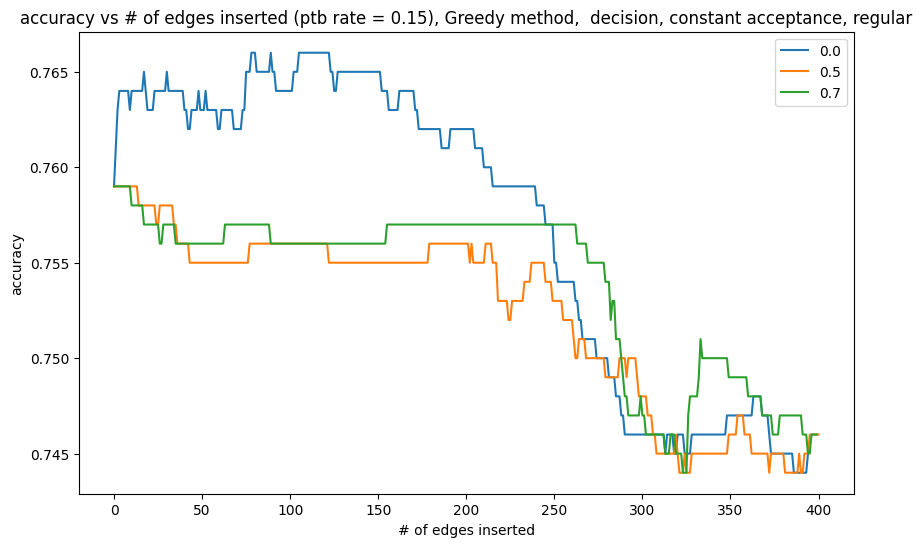

In [24]:
plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "regular")

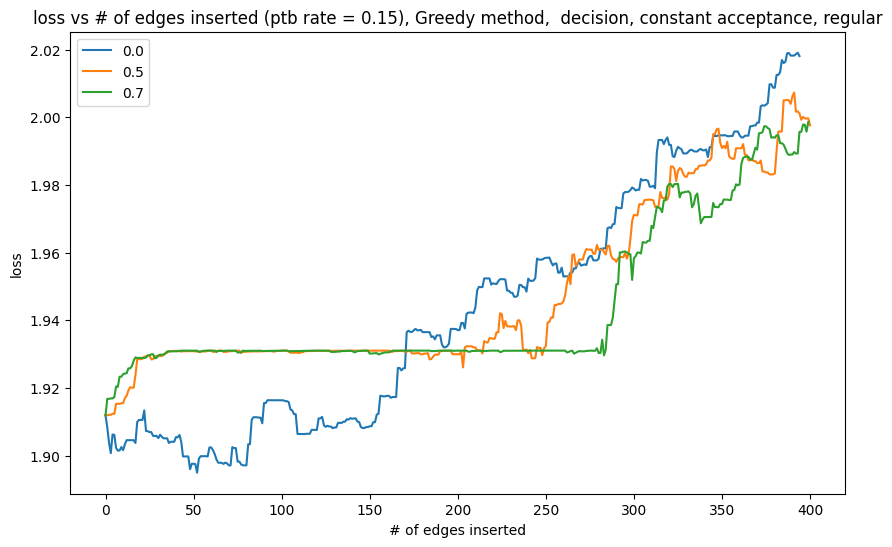

In [25]:
plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "regular")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [26]:
split_dic_decreasing_acc = defaultdict(list)
itrs_two = defaultdict(int)
split_dic_decreasing_loss = defaultdict(list)

In [27]:
for s in splits:
    if s == 0.0:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/197 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 40, Selected: 10
Attempt: 76, Selected: 20
Attempt: 77, Selected: 20
Attempt: 90, Selected: 30
Attempt: 120, Selected: 40
Attempt: 121, Selected: 40
Attempt: 153, Selected: 50
Attempt: 154, Selected: 50
Attempt: 155, Selected: 50
Attempt: 156, Selected: 50
Attempt: 157, Selected: 50
Attempt: 158, Selected: 50
Attempt: 159, Selected: 50
Attempt: 160, Selected: 50
Attempt: 161, Selected: 50
Attempt: 162, Selected: 50
Attempt: 163, Selected: 50
Attempt: 196, Selected: 60
Attempt: 197, Selected: 60
Attempt: 198, Selected: 60
Attempt: 199, Selected: 60
Attempt: 230, Selected: 70
Attempt: 255, Selected: 80
Attempt: 256, Selected: 80
Attempt: 257, Selected: 80
Attempt: 275, Selected: 90
Attempt: 276, Selected: 90
Attempt: 277, Selected: 90
Attempt: 278, Selected: 90
Attempt: 315, Selected: 100
Attempt: 353, Selected: 110
Attempt: 354, Selecte

Peturbing graph...:   0%|          | 0/203 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/118 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 50, Selected: 10
Attempt: 82, Selected: 20
Attempt: 83, Selected: 20
Attempt: 84, Selected: 20
Attempt: 113, Selected: 30
Attempt: 114, Selected: 30
Attempt: 115, Selected: 30
Attempt: 154, Selected: 40
Attempt: 155, Selected: 40
Attempt: 156, Selected: 40
Attempt: 157, Selected: 40
Attempt: 158, Selected: 40
Attempt: 159, Selected: 40
Attempt: 160, Selected: 40
Attempt: 161, Selected: 40
Attempt: 162, Selected: 40
Attempt: 163, Selected: 40
Attempt: 164, Selected: 40
Attempt: 165, Selected: 40
Attempt: 166, Selected: 40
Attempt: 167, Selected: 40
Attempt: 210, Selected: 50
Attempt: 211, Selected: 50
Attempt: 212, Selected: 50
Attempt: 213, Selected: 50
Attempt: 214, Selected: 50
Attempt: 215, Selected: 50
Attempt: 216, Selected: 50
Attempt: 217, Selected: 50
Attempt: 218, Selected: 50
Attempt: 247, Selected: 60
Attempt: 248, Selected:

Peturbing graph...:   0%|          | 0/123 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/39 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 69, Selected: 10
Attempt: 70, Selected: 10
Attempt: 117, Selected: 20
Attempt: 118, Selected: 20
Attempt: 119, Selected: 20
Attempt: 120, Selected: 20
Attempt: 185, Selected: 30
Attempt: 186, Selected: 30
Attempt: 187, Selected: 30
Attempt: 188, Selected: 30
Attempt: 228, Selected: 40
Attempt: 229, Selected: 40
Attempt: 230, Selected: 40
Attempt: 231, Selected: 40
Attempt: 277, Selected: 50
Attempt: 309, Selected: 60
Attempt: 310, Selected: 60
Attempt: 311, Selected: 60
Attempt: 312, Selected: 60
Attempt: 355, Selected: 70
Attempt: 390, Selected: 80
Attempt: 454, Selected: 90
Attempt: 493, Selected: 100
Attempt: 552, Selected: 110
Attempt: 553, Selected: 110
Attempt: 554, Selected: 110
Attempt: 555, Selected: 110
Attempt: 594, Selected: 120
Attempt: 595, Selected: 120
Attempt: 596, Selected: 120
Attempt: 597, Selected: 120
Attempt: 598

Peturbing graph...:   0%|          | 0/41 [00:00<?, ?it/s]

In [28]:
record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CORA, AcceptFn.INCREASING, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"increasing"}_{"attacked"}_results.pkl')

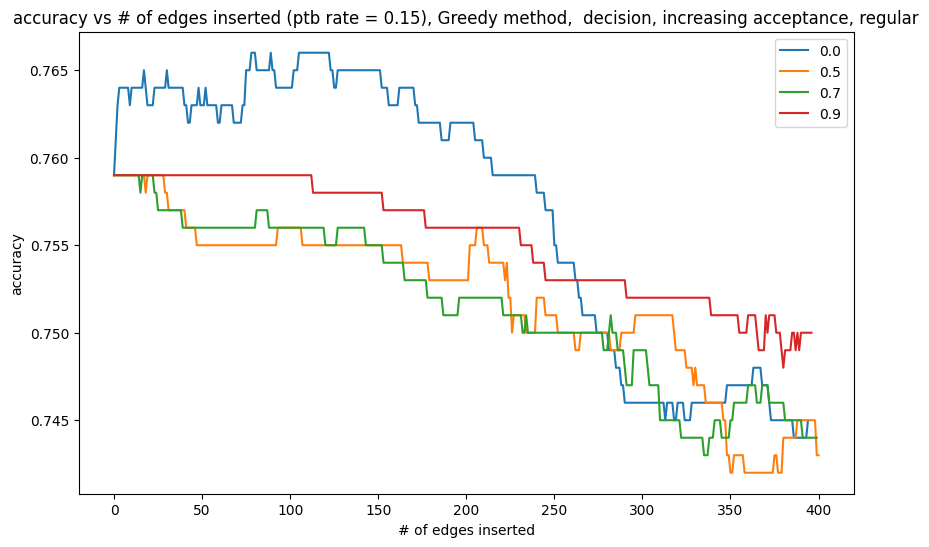

In [29]:
plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "regular")

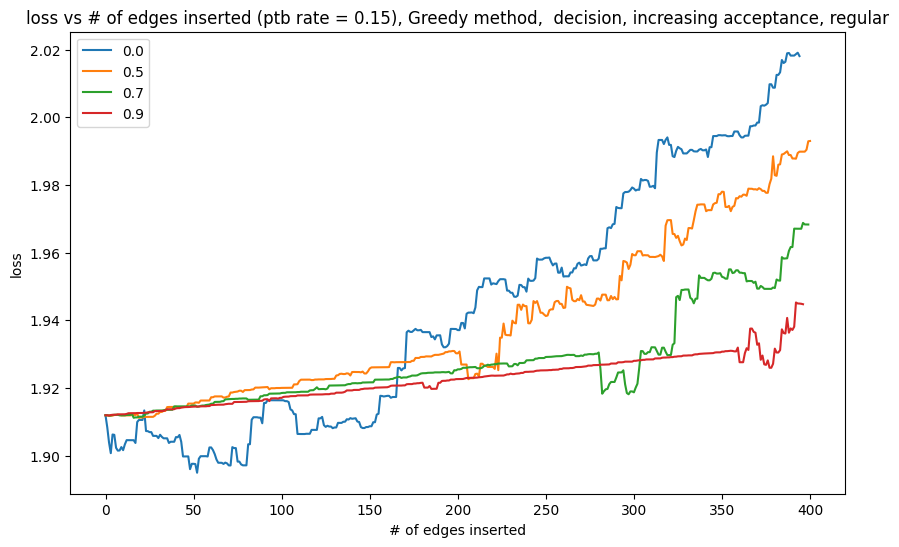

In [30]:
plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "regular")